In [9]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import cmocean
import xarray as xr
import xroms
import glob
import os
import datetime
import numpy as np
import dateutil
import dask
import pandas as pd

In [2]:
from dask.distributed import Client, LocalCluster
    #
cluster = LocalCluster(dashboard_address=':8787')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 251.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34343,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 251.08 GiB
Comm: tcp://127.0.0.1:38673,Total threads: 8
Dashboard: http://127.0.0.1:45865/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:40135,


In [132]:
data_path = '/southern/rbarkan/data/SWC2km/OUTPUT/W_rivers/HIS/'
save_path = '/meddy/lwang/data/SWC2km_Wrivers_data/'
figure_dir = '/meddy/lwang/figures/model_validation/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

In [4]:
grd = xr.open_dataset('/southern/rbarkan/data/SWC2km/SWC2km_grd.nc')
mask=grd.mask_rho
grd

<xarray.Dataset> Size: 210MB
Dimensions:     (eta_rho: 1296, xi_rho: 1502, eta_v: 1295, xi_u: 1501)
Dimensions without coordinates: eta_rho, xi_rho, eta_v, xi_u
Data variables: (12/21)
    angle       (eta_rho, xi_rho) float64 16MB ...
    cent_lat    float64 8B ...
    f           (eta_rho, xi_rho) float64 16MB ...
    flip_xy     float64 8B ...
    h           (eta_rho, xi_rho) float64 16MB ...
    hraw        (eta_rho, xi_rho) float64 16MB ...
    ...          ...
    spherical   |S1 1B ...
    tapering    float64 8B ...
    tra_lat     float64 8B ...
    tra_lon     float64 8B ...
    wgt         (eta_rho, xi_rho) float64 16MB ...
    river_flux  (eta_rho, xi_rho) float32 8MB ...
Attributes:
    Title:     ROMS grid produced by Easy Grid
    Settings:  nx=1500 ny=1294 size_x=3000 size_y=2500 cent_lat=55 tapering=0...
    Date:      16-Apr-2024
    history:   Thu Nov 21 11:12:03 2024: ncks -x -v river_flux SWC2km_grd.nc ...
    NCO:       netCDF Operators version 4.9.2-alpha05 (Homepage = http://nco....

In [5]:
filenames = sorted(glob.glob(data_path+'z_SWC2km_his.*.nc')) 
print('Number of files processed: %d' %len(filenames))

Number of files processed: 1460


In [6]:
ds = xr.open_mfdataset(filenames, concat_dim='time', combine="nested")
ds

<xarray.Dataset> Size: 2TB
Dimensions:     (time: 8760, depth: 5, eta_rho: 1296, xi_u: 1501, eta_v: 1295,
                 xi_rho: 1502)
Coordinates:
  * depth       (depth) float32 20B -2.0 -100.0 -500.0 -1e+03 -4e+03
Dimensions without coordinates: time, eta_rho, xi_u, eta_v, xi_rho
Data variables:
    ocean_time  (time) float64 70kB dask.array<chunksize=(6,), meta=np.ndarray>
    time_step   (time) int32 35kB dask.array<chunksize=(6,), meta=np.ndarray>
    u           (time, depth, eta_rho, xi_u) float32 341GB dask.array<chunksize=(6, 5, 1296, 1501), meta=np.ndarray>
    v           (time, depth, eta_v, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1295, 1502), meta=np.ndarray>
    temp        (time, depth, eta_rho, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    salt        (time, depth, eta_rho, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    w           (time, depth, eta_rho, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    Akv         (time, depth, eta_rho, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    Akt         (time, depth, eta_rho, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>

In [7]:
ds_sss = ds.salt.isel(depth=0)
ds_sss

<xarray.DataArray 'salt' (time: 8760, eta_rho: 1296, xi_rho: 1502)> Size: 68GB
dask.array<getitem, shape=(8760, 1296, 1502), dtype=float32, chunksize=(6, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
    depth    float32 4B -2.0
Dimensions without coordinates: time, eta_rho, xi_rho
Attributes:
    long_name:  salinity
    units:      PSU

In [8]:
print('\n data size: %.1f GB' %(ds_sss.nbytes / 1e9))


 data size: 68.2 GB


In [9]:
def oceantime_to_date(oceantime):
    t0 = datetime.datetime(2000,1,1)    
    ltime = np.array(oceantime)
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

    
dtime = oceantime_to_date(ds['ocean_time'])

In [10]:
ds_sss = ds_sss.assign_coords(time=dtime) 

In [11]:
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_sss = ds_sss.chunk(chunks)

In [12]:
%%time
ds_sss.to_zarr(save_path+'SSS_rechunk.zarr',mode='w')

CPU times: user 6min 20s, sys: 2min 2s, total: 8min 22s
Wall time: 1h 28min 46s


In [13]:
ds_sss = xr.open_zarr(save_path + 'SSS_rechunk.zarr')
print(ds_sss)
print('\n data size: %.1f GB' %(ds_sss.nbytes / 1e9))

<xarray.Dataset> Size: 68GB
Dimensions:  (time: 8760, eta_rho: 1296, xi_rho: 1502)
Coordinates:
    depth    float32 4B ...
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt     (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 68.2 GB


In [14]:
ds_sss_daily = ds_sss.resample(time='D').mean()
print('\n data size: %.1f GB' %(ds_sss_daily.nbytes / 1e9))


 data size: 2.8 GB


In [15]:
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_sss_daily = ds_sss_daily.chunk(chunks)

In [16]:
%%time
ds_sss_daily.to_zarr(save_path+'SSS_daily_rechunk.zarr',mode='w')

CPU times: user 21.4 s, sys: 5.17 s, total: 26.6 s
Wall time: 47 s


In [9]:
ds_sss = xr.open_zarr(save_path + 'SSS_daily_rechunk.zarr')

In [10]:
ds_sss_summer1 = ds_sss.sel(time=slice("2016-07-31", "2016-09-30") )
ds_sss_summer2 = ds_sss.sel(time=slice("2017-05-01", "2017-7-31") )

ds_sss_summer = xr.concat([ds_sss_summer1, ds_sss_summer2], dim='time')
ds_sss_summer

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 154, eta_rho: 1296, xi_rho: 1502)
Coordinates:
    depth    float32 4B ...
  * time     (time) datetime64[ns] 1kB 2016-07-31 2016-08-01 ... 2017-07-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt     (time, eta_rho, xi_rho) float32 1GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [11]:
ds_sss_winter = ds_sss.sel(time=slice("2016-11-01", "2017-03-31") )
ds_sss_winter

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 151, eta_rho: 1296, xi_rho: 1502)
Coordinates:
    depth    float32 4B ...
  * time     (time) datetime64[ns] 1kB 2016-11-01 2016-11-02 ... 2017-03-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt     (time, eta_rho, xi_rho) float32 1GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [12]:
annual_mean_sss = ds_sss.mean(dim='time')
annual_mean_sss = annual_mean_sss.where(mask > 0)
annual_mean_sss

<xarray.Dataset> Size: 8MB
Dimensions:  (eta_rho: 1296, xi_rho: 1502)
Coordinates:
    depth    float32 4B ...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt     (eta_rho, xi_rho) float32 8MB dask.array<chunksize=(1296, 1502), meta=np.ndarray>

In [13]:
summer_mean_sss = ds_sss_summer.mean(dim='time')
summer_mean_sss = summer_mean_sss.where(mask > 0)

winter_mean_sss = ds_sss_winter.mean(dim='time')
winter_mean_sss = winter_mean_sss.where(mask > 0)

CPU times: user 8.02 s, sys: 1.27 s, total: 9.29 s
Wall time: 9.75 s


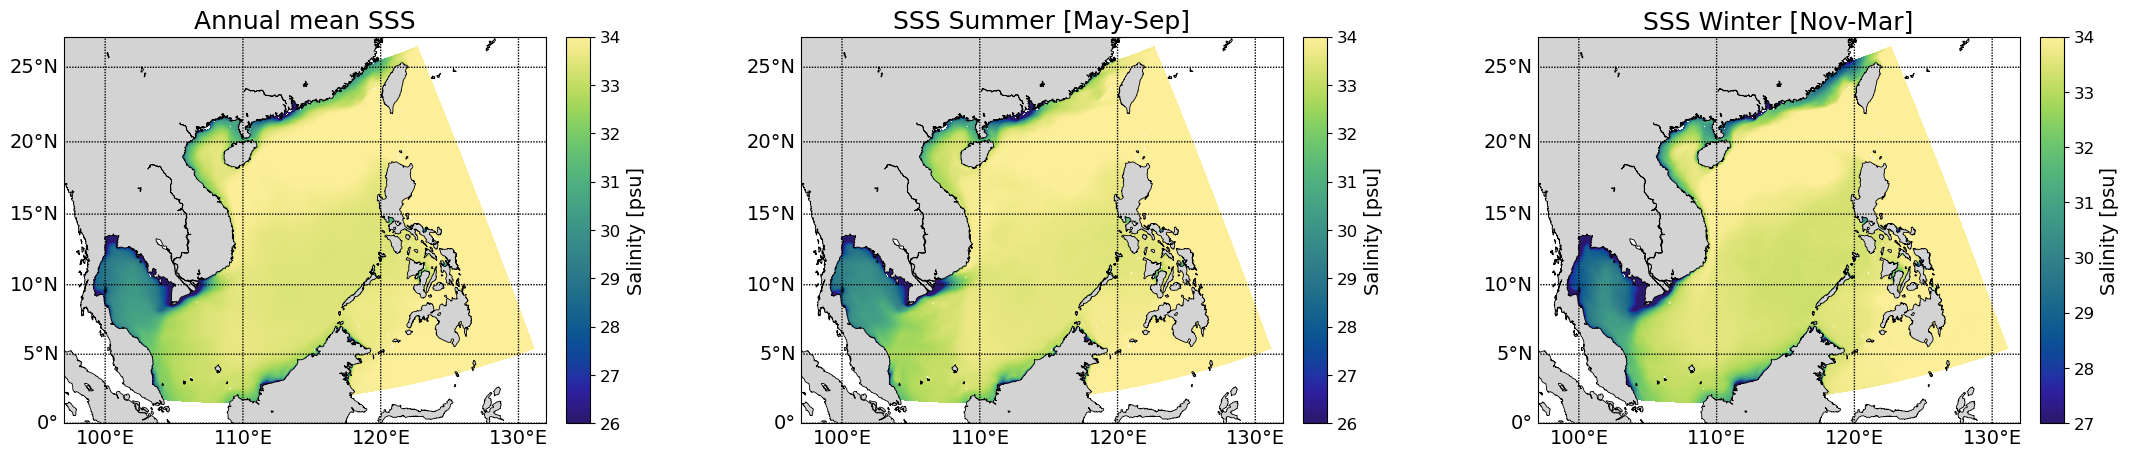

In [26]:
%%time
fig = plt.figure(figsize=(25, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.35)

ax = fig.add_subplot(131)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_sss.salt, vmin=26, vmax=34, cmap=cmocean.cm.haline)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax)
cbar.ax.set_ylabel('Salinity [psu]', fontsize=14)
cbar.ax.tick_params(labelsize='large')
ax.set_title('Annual mean SSS', fontsize=18)


ax = fig.add_subplot(132)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, summer_mean_sss.salt, vmin=26, vmax=34, cmap=cmocean.cm.haline)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax)
cbar.ax.set_ylabel('Salinity [psu]', fontsize=14)
cbar.ax.tick_params(labelsize='large')
ax.set_title('SSS Summer [May-Sep]', fontsize=18)


ax = fig.add_subplot(133)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, winter_mean_sss.salt, vmin=27, vmax=34, cmap=cmocean.cm.haline)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax)
cbar.ax.set_ylabel('Salinity [psu]', fontsize=14)
cbar.ax.tick_params(labelsize='large')
ax.set_title('SSS Winter [Nov-Mar]', fontsize=18)

plt.savefig(figure_dir +'composite_sss_daily_annualmean.png', bbox_inches='tight', dpi=500)

CPU times: user 2.67 s, sys: 373 ms, total: 3.05 s
Wall time: 4.7 s


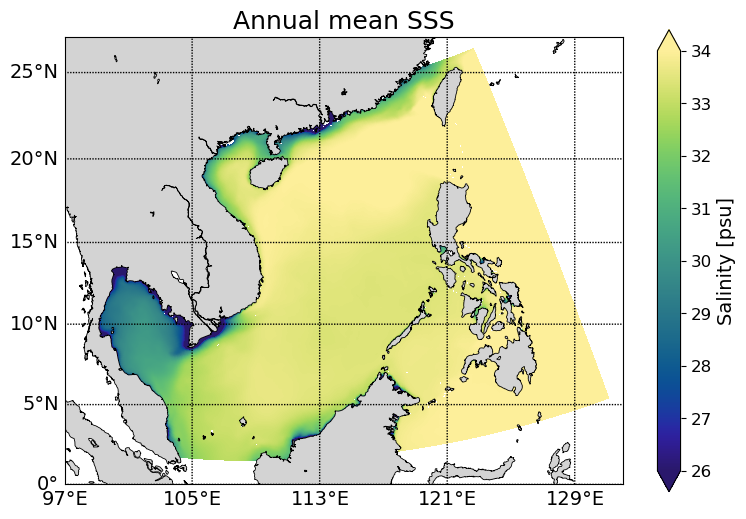

In [12]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_sss.salt, vmin=26, vmax=34, cmap=cmocean.cm.haline)
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.set_ylabel('Salinity [psu]', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.title('Annual mean SSS', fontsize=18)
plt.savefig(figure_dir +'sss_daily_annualmean.png', bbox_inches='tight', dpi=500)

CPU times: user 2.41 s, sys: 291 ms, total: 2.7 s
Wall time: 3.07 s


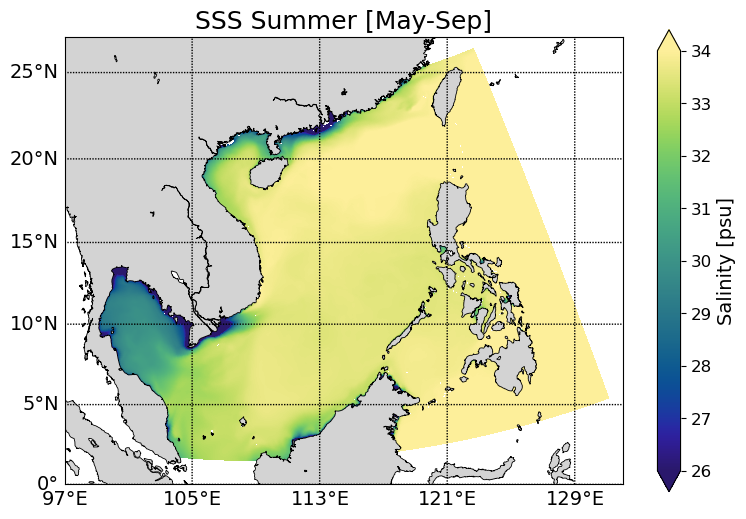

In [13]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, summer_mean_sss.salt, vmin=26, vmax=34, cmap=cmocean.cm.haline)
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.set_ylabel('Salinity [psu]', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.title('SSS Summer [May-Sep]', fontsize=18)
plt.savefig(figure_dir +'sss_daily_summermean.png', bbox_inches='tight', dpi=500)

CPU times: user 2.43 s, sys: 249 ms, total: 2.68 s
Wall time: 3.03 s


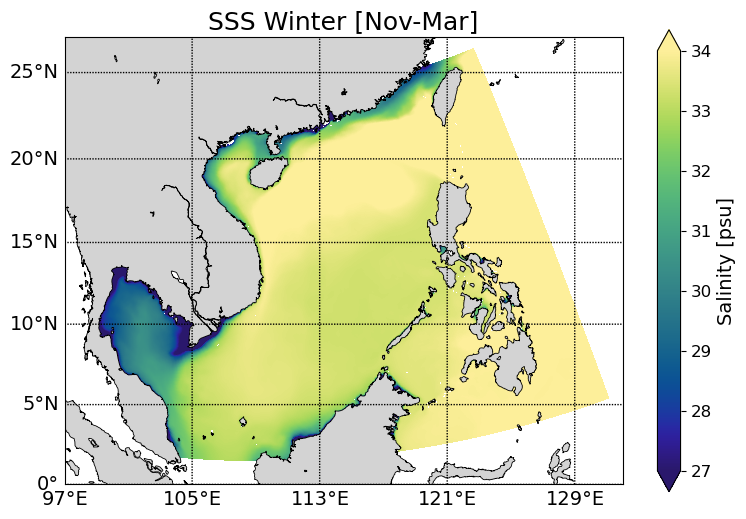

In [14]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, winter_mean_sss.salt, vmin=27, vmax=34, cmap=cmocean.cm.haline)
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.set_ylabel('Salinity [psu]', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.title('SSS Winter [Nov-Mar]', fontsize=18)
plt.savefig(figure_dir +'sss_daily_wintermean.png', bbox_inches='tight', dpi=500)

In [18]:
ds_sst = ds.temp.isel(depth=0)
ds_sst

NameError: name 'ds' is not defined

In [23]:
print('\n data size: %.1f GB' %(ds_sst.nbytes / 1e9))


 data size: 68.2 GB


In [24]:
def oceantime_to_date(oceantime):
    t0 = datetime.datetime(2000,1,1)    
    ltime = np.array(oceantime)
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

    
dtime = oceantime_to_date(ds['ocean_time'])

In [25]:
ds_sst = ds_sst.assign_coords(time=dtime) 

In [63]:
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_sst = ds_sst.chunk(chunks)

In [64]:
%%time
ds_sst.to_zarr(save_path+'SST_rechunk.zarr',mode='w')

CPU times: user 2min 54s, sys: 1min 39s, total: 4min 33s
Wall time: 1h 23min 23s


In [65]:
ds_sst = xr.open_zarr(save_path + 'SST_rechunk.zarr')
print(ds_sst)
print('\n data size: %.1f GB' %(ds_sst.nbytes / 1e9))

<xarray.Dataset> Size: 68GB
Dimensions:  (time: 8760, eta_rho: 1296, xi_rho: 1502)
Coordinates:
    depth    float32 4B ...
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp     (time, eta_rho, xi_rho) float32 68GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 68.2 GB


In [66]:
ds_sst_daily = ds_sst.resample(time='D').mean()
print('\n data size: %.1f GB' %(ds_sst_daily.nbytes / 1e9))


 data size: 2.8 GB


In [67]:
chunks = {'time': 1, 'eta_rho': 1296, 'xi_rho': 1502}
ds_sst_daily = ds_sst_daily.chunk(chunks)

In [68]:
%%time
ds_sst_daily.to_zarr(save_path+'SST_daily_rechunk.zarr',mode='w')

CPU times: user 19.7 s, sys: 8.64 s, total: 28.3 s
Wall time: 1min 8s


In [19]:
ds_sst = xr.open_zarr(save_path + 'SST_daily_rechunk.zarr')

In [20]:
ds_sst_summer1 = ds_sst.sel(time=slice("2016-07-31", "2016-09-30") )
ds_sst_summer2 = ds_sst.sel(time=slice("2017-05-01", "2017-7-31") )

ds_sst_summer = xr.concat([ds_sst_summer1, ds_sst_summer2], dim='time')
ds_sst_summer

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 154, eta_rho: 1296, xi_rho: 1502)
Coordinates:
    depth    float32 4B ...
  * time     (time) datetime64[ns] 1kB 2016-07-31 2016-08-01 ... 2017-07-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp     (time, eta_rho, xi_rho) float32 1GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [21]:
ds_sst_winter = ds_sst.sel(time=slice("2016-11-01", "2017-03-31") )
ds_sst_winter

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 151, eta_rho: 1296, xi_rho: 1502)
Coordinates:
    depth    float32 4B ...
  * time     (time) datetime64[ns] 1kB 2016-11-01 2016-11-02 ... 2017-03-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp     (time, eta_rho, xi_rho) float32 1GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [22]:
annual_mean_sst = ds_sst.mean(dim='time')
annual_mean_sst = annual_mean_sst.where(mask > 0)
annual_mean_sst

<xarray.Dataset> Size: 8MB
Dimensions:  (eta_rho: 1296, xi_rho: 1502)
Coordinates:
    depth    float32 4B ...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp     (eta_rho, xi_rho) float32 8MB dask.array<chunksize=(1296, 1502), meta=np.ndarray>

In [23]:
summer_mean_sst = ds_sst_summer.mean(dim='time')
summer_mean_sst = summer_mean_sst.where(mask > 0)

winter_mean_sst = ds_sst_winter.mean(dim='time')
winter_mean_sst = winter_mean_sst.where(mask > 0)

CPU times: user 8.05 s, sys: 1.11 s, total: 9.16 s
Wall time: 9.72 s


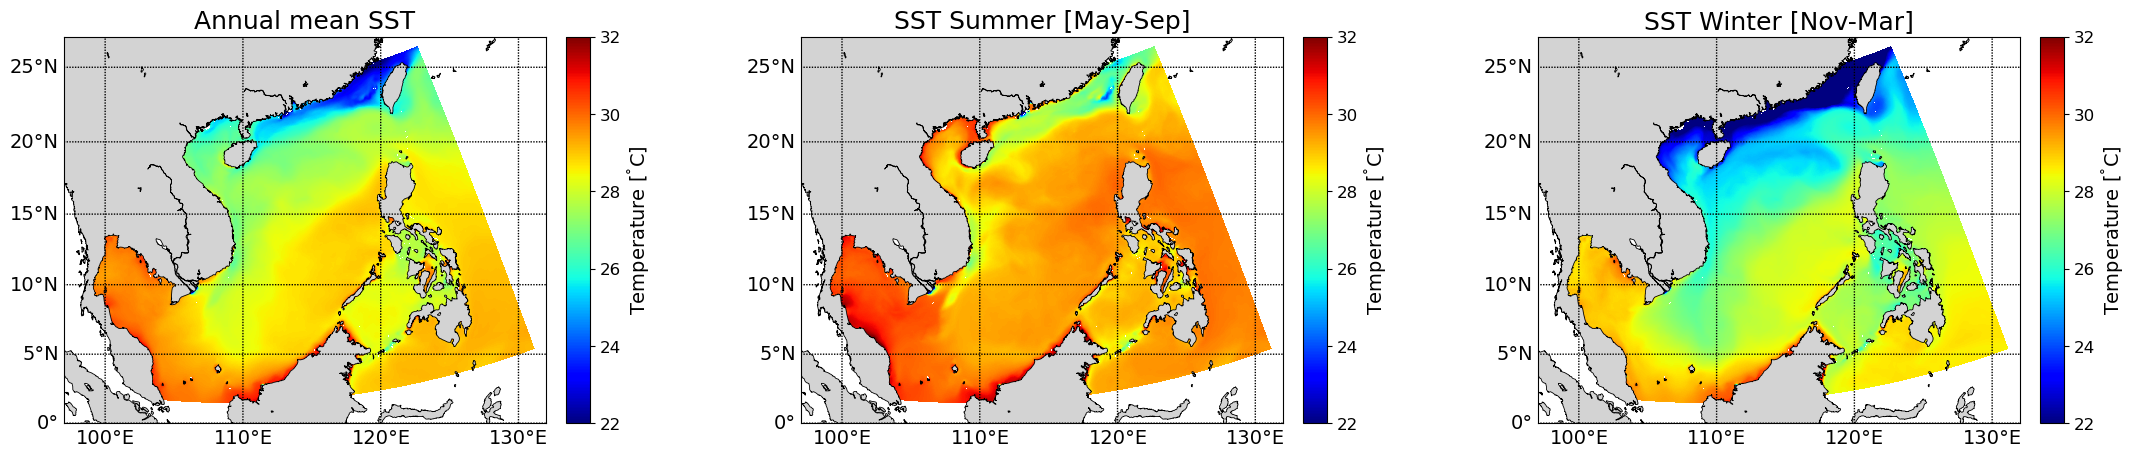

In [25]:
%%time
fig = plt.figure(figsize=(25, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.35)

ax = fig.add_subplot(131)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_sst.temp, vmin=22, vmax=32, cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax)
cbar.ax.set_ylabel('Temperature [' + r'$^\degree$' + 'C]', fontsize=14)
cbar.ax.tick_params(labelsize='large')
ax.set_title('Annual mean SST', fontsize=18)


ax = fig.add_subplot(132)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, summer_mean_sst.temp, vmin=22, vmax=32, cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax)
cbar.ax.set_ylabel('Temperature [' + r'$^\degree$' + 'C]', fontsize=14)
cbar.ax.tick_params(labelsize='large')
ax.set_title('SST Summer [May-Sep]', fontsize=18)



ax = fig.add_subplot(133)
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(100,140,10),labels=[0,0,0,1], fontsize=14)
xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, winter_mean_sst.temp, vmin=22, vmax=32, cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(plot,cax=cax)
cbar.ax.set_ylabel('Temperature [' + r'$^\degree$' + 'C]', fontsize=14)
cbar.ax.tick_params(labelsize='large')
ax.set_title('SST Winter [Nov-Mar]', fontsize=18)

plt.savefig(figure_dir +'composite_sst_daily_annualmean.png', bbox_inches='tight', dpi=500)

CPU times: user 2.66 s, sys: 281 ms, total: 2.94 s
Wall time: 3.91 s


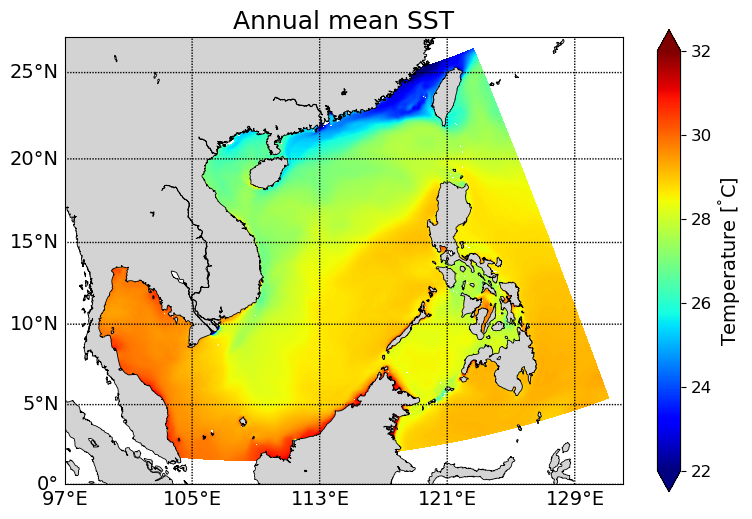

In [20]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, annual_mean_sst.temp, vmin=22, vmax=32, cmap='jet')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.set_ylabel('Temperature [' + r'$^\degree$' + 'C]', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.title('Annual mean SST', fontsize=18)
plt.savefig(figure_dir +'sst_daily_annualmean.png', bbox_inches='tight', dpi=500)

CPU times: user 2.48 s, sys: 323 ms, total: 2.81 s
Wall time: 3.13 s


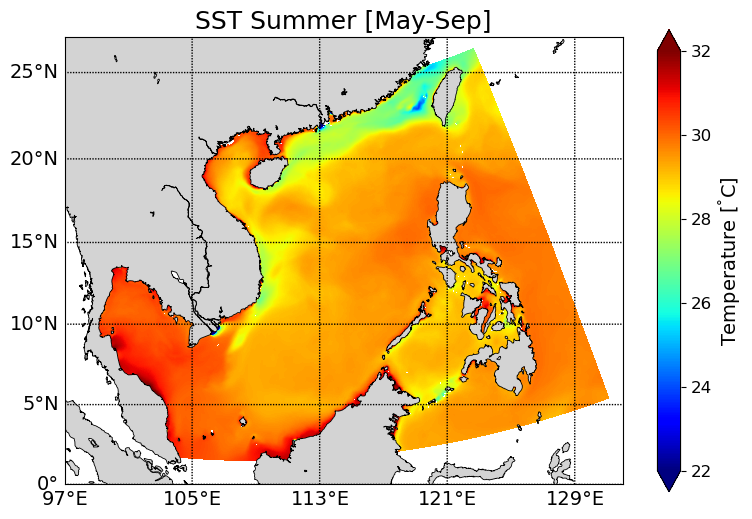

In [21]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, summer_mean_sst.temp, vmin=22, vmax=32, cmap='jet')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.set_ylabel('Temperature [' + r'$^\degree$' + 'C]', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.title('SST Summer [May-Sep]', fontsize=18)
plt.savefig(figure_dir +'sst_daily_summermean.png', bbox_inches='tight', dpi=500)

CPU times: user 2.39 s, sys: 240 ms, total: 2.63 s
Wall time: 3.09 s


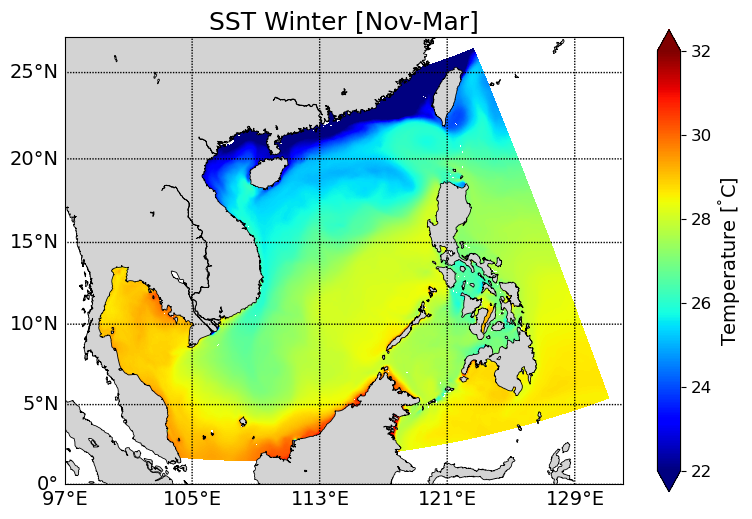

In [22]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='i')
m.drawcoastlines(linewidth=0.6)
m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)


xp, yp = m(grd['lon_rho'], grd['lat_rho'])
plot = m.pcolormesh(xp, yp, winter_mean_sst.temp, vmin=22, vmax=32, cmap='jet')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.set_ylabel('Temperature [' + r'$^\degree$' + 'C]', fontsize=14)
cbar.ax.tick_params(labelsize='large')


plt.title('SST Winter [Nov-Mar]', fontsize=18)
plt.savefig(figure_dir +'sst_daily_wintermean.png', bbox_inches='tight', dpi=500)

In [28]:
ds = xr.open_dataset('/meddy/lwang/data/WOA/woa23_B5C2_t00_04.nc',decode_times=False)
units, reference_date = ds.time.attrs['units'].split('since')
ds['time'] = pd.date_range(start=reference_date, periods=ds.sizes['time'], freq='MS')
ds

<xarray.Dataset> Size: 5GB
Dimensions:             (lat: 720, nbounds: 2, lon: 1440, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon                 (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * depth               (depth) float32 408B 0.0 5.0 10.0 ... 5.4e+03 5.5e+03
  * time                (time) datetime64[ns] 8B 2015-01-01
Dimensions without coordinates: nbounds
Data variables: (12/14)
    crs                 int32 4B ...
    lat_bnds            (lat, nbounds) float32 6kB ...
    lon_bnds            (lon, nbounds) float32 12kB ...
    depth_bnds          (depth, nbounds) float32 816B ...
    climatology_bounds  (time, nbounds) float32 8B ...
    t_an                (time, depth, lat, lon) float32 423MB ...
    ...                  ...
    t_sd                (time, depth, lat, lon) float32 423MB ...
    t_se                (time, depth, lat, lon) float32 423MB ...
    t_oa                (time, depth, lat, lon) float32 423MB ...
    t_gp                (time, depth, lat, lon) float64 846MB ...
    t_sdo               (time, depth, lat, lon) float32 423MB ...
    t_sea               (time, depth, lat, lon) float32 423MB ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2023 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R.A., A.V. Mishonov, O.K. Bar...
    institution:                     NOAA National Centers for Environmental ...
    comment:                         Global Climatology as part of the World ...
    ...                              ...
    ncei_template_version:           NCEI_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   https://www.ncei.noaa.gov/products/world...
    date_created:                    2024-01-28 
    date_modified:                   2024-01-28

In [16]:
ds_sst = ds.t_an.isel(depth=0)

In [22]:
ds.lon

<xarray.DataArray 'lon' (lon: 1440)> Size: 6kB
array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X
    bounds:         lon_bnds

In [113]:
lon_min, lon_max = 97.125, 132.125
lat_min, lat_max = 0.125, 27.125

In [114]:
ds_sst_sel = ds_sst_sel.where(
    (ds.lat >= lat_min) & (ds.lat <= lat_max) &
    (ds.lon >= lon_min) & (ds.lon <= lon_max),
    drop=True
)

In [115]:
ds_sst_sel

<xarray.DataArray 't_an' (time: 1, lat: 108, lon: 140)> Size: 60kB
array([[[29.551191, 29.55381 , 29.57169 , ..., 29.4437  , 29.47649 ,
         29.56839 ],
        [29.53701 , 29.59959 , 29.65391 , ..., 29.60219 , 29.610409,
         29.65631 ],
        [29.53549 , 29.72559 , 29.71531 , ..., 29.66991 , 29.68241 ,
         29.7076  ],
        ...,
        [      nan,       nan,       nan, ..., 25.55971 , 25.5489  ,
         25.54519 ],
        [      nan,       nan,       nan, ..., 25.494091, 25.472391,
         25.45249 ],
        [      nan,       nan,       nan, ..., 25.44291 , 25.40999 ,
         25.37809 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 432B 0.125 0.375 0.625 0.875 ... 26.38 26.62 26.88
  * lon      (lon) float32 560B 97.12 97.38 97.62 97.88 ... 131.4 131.6 131.9
  * time     (time) datetime64[ns] 8B 2015-01-01
    depth    float32 4B 0.0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [89]:
ds_sst_sel[0]

<xarray.DataArray 't_an' (lat: 108, lon: 140)> Size: 60kB
array([[29.551191, 29.55381 , 29.57169 , ..., 29.4437  , 29.47649 , 29.56839 ],
       [29.53701 , 29.59959 , 29.65391 , ..., 29.60219 , 29.610409, 29.65631 ],
       [29.53549 , 29.72559 , 29.71531 , ..., 29.66991 , 29.68241 , 29.7076  ],
       ...,
       [      nan,       nan,       nan, ..., 25.55971 , 25.5489  , 25.54519 ],
       [      nan,       nan,       nan, ..., 25.494091, 25.472391, 25.45249 ],
       [      nan,       nan,       nan, ..., 25.44291 , 25.40999 , 25.37809 ]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 432B 0.125 0.375 0.625 0.875 ... 26.38 26.62 26.88
  * lon      (lon) float32 560B 97.12 97.38 97.62 97.88 ... 131.4 131.6 131.9
    depth    float32 4B 0.0
    time     datetime64[ns] 8B 2015-01-01
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

CPU times: user 385 ms, sys: 28.6 ms, total: 413 ms
Wall time: 450 ms


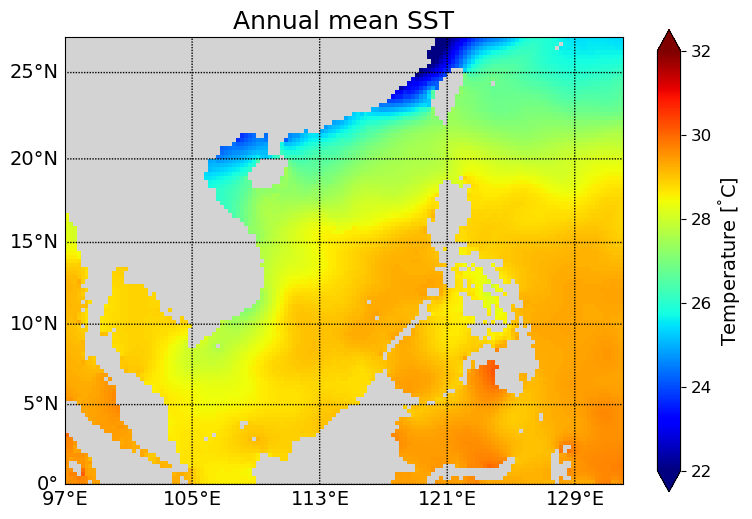

In [133]:
%%time
fig, ax = plt.subplots(1,1,figsize=(9.,6.))
m = Basemap(projection='merc',llcrnrlat=0,urcrnrlat=27,\
            llcrnrlon=97,urcrnrlon=132,lat_ts=20,resolution='c')
#m.drawcoastlines(linewidth=0.6)
#m.fillcontinents(color='lightgrey');
m.drawparallels(np.arange(0,30,5),labels=[1,0,0,0], fontsize=14)
m.drawmeridians(np.arange(97,137,8),labels=[0,0,0,1], fontsize=14)

lon2d, lat2d = np.meshgrid(ds_sst_sel.lon.values, ds_sst_sel.lat.values)
xp, yp = m(lon2d,lat2d)
cmap = plt.cm.jet.copy()
cmap.set_bad(color='lightgray')
plot = m.pcolormesh(xp, yp, ds_sst_sel[0], vmin=22, vmax=32, cmap=cmap)
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.set_ylabel('Temperature [' + r'$^\degree$' + 'C]', fontsize=14)
cbar.ax.tick_params(labelsize='large')

plt.title('Annual mean SST', fontsize=18)
plt.savefig(figure_dir +'woa_sst_2015-2022_annualmean.png', bbox_inches='tight', dpi=500)

In [35]:
grd = xr.open_dataset('/southern/rbarkan/data/SWC2km/SWC2km_grd.nc')
grd

<xarray.Dataset> Size: 210MB
Dimensions:     (eta_rho: 1296, xi_rho: 1502, eta_v: 1295, xi_u: 1501)
Dimensions without coordinates: eta_rho, xi_rho, eta_v, xi_u
Data variables: (12/21)
    angle       (eta_rho, xi_rho) float64 16MB ...
    cent_lat    float64 8B ...
    f           (eta_rho, xi_rho) float64 16MB ...
    flip_xy     float64 8B ...
    h           (eta_rho, xi_rho) float64 16MB ...
    hraw        (eta_rho, xi_rho) float64 16MB ...
    ...          ...
    spherical   |S1 1B ...
    tapering    float64 8B ...
    tra_lat     float64 8B ...
    tra_lon     float64 8B ...
    wgt         (eta_rho, xi_rho) float64 16MB ...
    river_flux  (eta_rho, xi_rho) float32 8MB ...
Attributes:
    Title:     ROMS grid produced by Easy Grid
    Settings:  nx=1500 ny=1294 size_x=3000 size_y=2500 cent_lat=55 tapering=0...
    Date:      16-Apr-2024
    history:   Thu Nov 21 11:12:03 2024: ncks -x -v river_flux SWC2km_grd.nc ...
    NCO:       netCDF Operators version 4.9.2-alpha05 (Homepage = http://nco....

In [38]:
grd['lon_rho'][0,:].values

array([ 97.66378677,  97.68605476,  97.70832422, ..., 131.11866847,
       131.14002044, 131.16136998])

In [39]:
grd['lon_rho'][1,:].values

array([ 97.66806468,  97.69032463,  97.71258604, ..., 131.1108178 ,
       131.13216233, 131.15350444])

In [40]:
grd['lon_rho'][:,0].values

array([ 97.66378677,  97.66806468,  97.67234113, ..., 102.21688455,
       102.219768  , 102.22265057])